In [18]:
import utils.game_utils as gu
import utils.plot as guplot

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

DATA_PATH = '../../data'
nfld = gu.NFL_Data(DATA_PATH)

Text(0.5, 0.98, 'Is having the most yards previously a predictor? : 2010-2021')

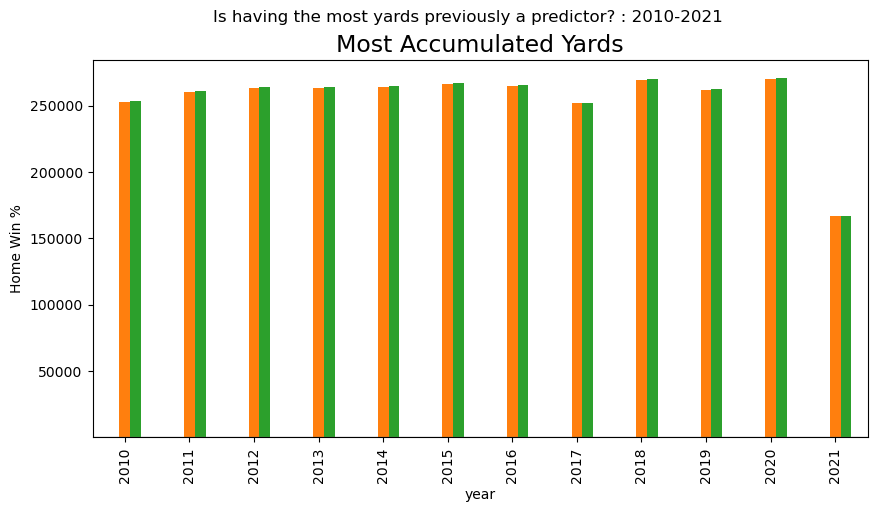

In [10]:

def get_win_with_more_points_per_for_week(week):
  home_df = nfld.data_by_game()
  week_df = home_df[home_df['week'] == week]
  game_count = len(week_df)
  wins_with_more_points = len(week_df[(
      (week_df['win'] == 1)&(week_df['team_cml_points_before'] > week_df['opponent_cml_points_before']) |
      (week_df['win'] == 0)&(week_df['team_cml_points_before'] <= week_df['opponent_cml_points_before'])
    )])
  
  return (wins_with_more_points / game_count * 100, wins_with_more_points)

nfl_df = nfld.data_by_team()
samp_df = nfl_df[['year', 'win', 'team_cml_total_yards_before','opponent_cml_total_yards_before']]

win_perc_year_df = samp_df.groupby('year').sum() / samp_df.groupby('year').count() * 100
win_perc_year_df

# -- charting
fig, ax = plt.subplots(figsize=(10,5),dpi=100)
win_perc_year_df.plot(kind='bar', ax=ax, legend=None)
# for p in ax.patches:                 
#   ax.annotate(np.round(p.get_height(),decimals=2), 
#               (p.get_x()+p.get_width()/2., p.get_height()),                              
#               ha='center',                              
#               va='center',                              
#               xytext=(0, 10),                               
#               textcoords='offset points')
plt.axhline(y=50, color='gray', linestyle='-', lw=1, alpha=0.6)
plt.ylim(bottom=40)
plt.ylabel('Home Win %');
plt.title('Most Accumulated Yards', fontsize=17)
plt.suptitle('Is having the most yards previously a predictor? : 2010-2021')


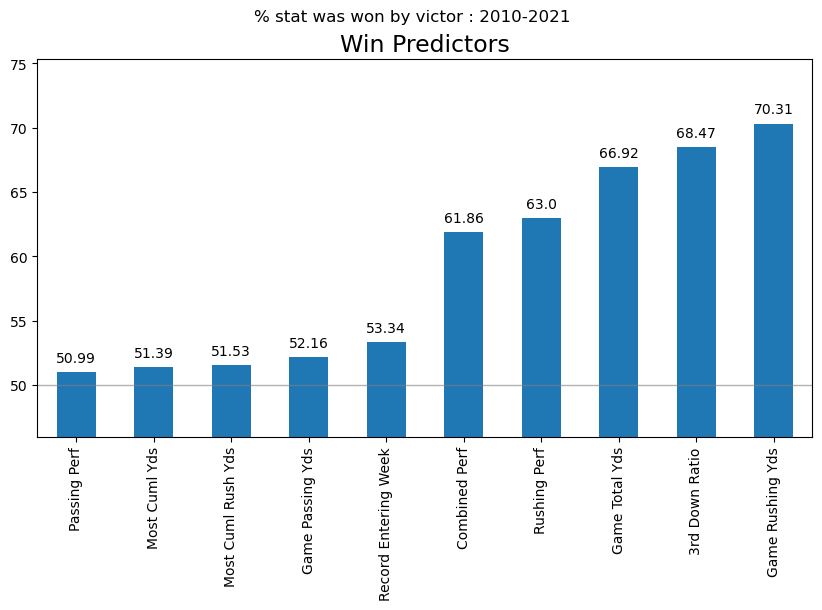

In [6]:

def add_did_gt_win(df, new_fieldname, root_test_field_name):
  df[new_fieldname] = ((df['win']) & (df[f'team_{root_test_field_name}'] > df[f'opponent_{root_test_field_name}'])) | ((df['win'] == 0) & (df[f'team_{root_test_field_name}'] <= df[f'opponent_{root_test_field_name}']))

# need to copy as we will be adding these new results as fields
# df = nfld.data_by_game().copy()
df = nfld.data_by_game()
# df = df[df['year'] > 2015]
df = df.copy()

conf_list = [
  ('top_pass_won', 'pass_yards', 'Game Passing Yds'),
  ('top_rush_won', 'rush_yards', 'Game Rushing Yds'),
  ('top_total_won', 'total_yards', 'Game Total Yds'),
  ('cml_top_rush_b4_won', 'cml_rush_yards_before', 'Most Cuml Rush Yds'),
  ('cml_top_total_b4_won', 'cml_total_yards_before', 'Most Cuml Yds'),
  ('top_total_pass_comp_perf_won', 'week_pass_comp_perf', 'Passing Perf'),
  ('top_total_rush_comp_perf_won', 'week_rush_comp_perf', 'Rushing Perf'),
  ('top_total_comb_comp_perf_won', 'week_comb_comp_perf', 'Combined Perf'),
  ('top_third_dwn_ratio_won', 'third_down_ratio', '3rd Down Ratio'),
  ('top_record_normal_before_won', 'record_normal_before', 'Record Entering Week'),
]

columns = []
fields = []
for conf_item in conf_list:
  new_fieldname, root_test_field_name, col_label = conf_item
  add_did_gt_win(df, new_fieldname, root_test_field_name)
  columns.append(col_label)
  fields.append(new_fieldname)

data_df = df[['year'] + fields]

### NOW PLOT
count = len(data_df)

c_data = data_df.drop('year', axis=1)
c_data.columns = columns
c_data = (c_data.sum() / count * 100).sort_values()

mmin = c_data.min() - 5
mmax = c_data.max() + 5
min_year = df['year'].min()
max_year = df['year'].max()

fig, ax = plt.subplots(figsize=(10,5),dpi=100)
c_data.plot(kind="bar")
plt.ylim(mmin,mmax)
plt.axhline(y=50, color='gray', linestyle='-', lw=1, alpha=0.6)
plt.title('Win Predictors', fontsize=17)
plt.suptitle(f'% stat was won by victor : {min_year}-{max_year}')

for p in ax.patches:                 
  ax.annotate(np.round(p.get_height(),decimals=2), 
              (p.get_x()+p.get_width()/2., p.get_height()),                              
              ha='center',                              
              va='center',                              
              xytext=(0, 10),                               
              textcoords='offset points')


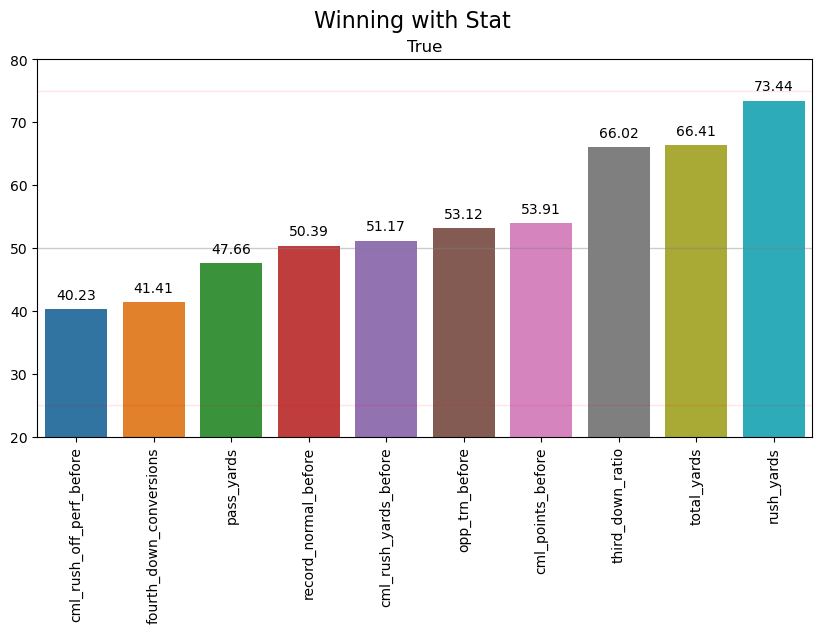

In [21]:
import importlib
importlib.reload(guplot) # every run
###
### WIN PREDICTORS
###

df = nfld.data_by_game()
df = df[df['year'] == 2018]
# df = df[df['week'] == 14]

fields = [
    'record_normal_before',
    'third_down_ratio',
    'cml_points_before',
    'cml_rush_yards_before',
    'cml_rush_off_perf_before',
    'fourth_down_conversions',
    'opp_trn_before',
    'rush_yards',
    'pass_yards',
    'total_yards',
]
data = {}
for field in fields:
    perc, total = gu.get_wins_with_more_in_field(df, field)
    data[field] = perc

for item in data:
    data[item] = [data[item]]
pdf = pd.DataFrame(data)
# sort the columns
pdf = pdf.T.sort_values(by=0).T
guplot.bar_percent_plot(pdf, 
                        suptitle="Winning with Stat", 
                        title=True, 
                        ylimit=(20,80))


In [8]:

### 
### CML PERCENTAGES
### 

def get_perc(df, field):
  '''
  Given a df and a field, return the number of time the 
  winning team lead in that field.
  
  If there is a '!' in the field name the invert the 
  logic
  '''
  if field.startswith('!'):
    field = field.replace('!','')
    wins_df = df[
      ((df['win'] == 0) & (df[f'team_{field}'] > df[f'opponent_{field}']))|
      ((df['win'] == 1) & (df[f'team_{field}'] <= df[f'opponent_{field}']))
    ]
  else:
    wins_df = df[
        ((df['win'] == 1) & (df[f'team_{field}'] > df[f'opponent_{field}']))|
        ((df['win'] == 0) & (df[f'team_{field}'] <= df[f'opponent_{field}']))
      ]

  return (len(wins_df) / len(df)) * 100
def plot_data(dfOrData, min_year=0, max_year=0):
  if isinstance(dfOrData, pd.DataFrame):
    pdf = dfOrData
  else:
    for item in dfOrData: dfOrData[item] = [dfOrData[item]]
    pdf = pd.DataFrame(dfOrData)
  
  ymin = min(45, pdf.T.min()[0] - 5)
  ymax = max(55, pdf.T.max()[0] + 5)
    
  fig, ax = plt.subplots(figsize=(10,5),dpi=100)
  # plt.figure(figsize=(10,6), dpi=150)
  sns.barplot(data=pdf, ax=ax)
  # plt.ylim(ymin, ymax)
  plt.xticks(rotation=90);
  plt.suptitle('Win % when leading in a stat:', fontsize=16)
  if min_year == max_year:
    plt.title(f'{min_year}')
  else:
    plt.title(f'{min_year} - {max_year}')
  plt.axhline(y=50, color='gray', linestyle='-', lw=1, alpha=0.3)
  # plt.axhline(y=75, color='gray', linestyle='-', lw=1, alpha=0.3)
  # plt.axhline(y=25, color='gray', linestyle='-', lw=1, alpha=0.3)
  for p in ax.patches:                 
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()),                              
                ha='center',                              
                va='center',                              
                xytext=(0, 10),                               
                textcoords='offset points')
def work_fields_by_year(df, fields):
  for field in fields:
    data = {}
    
    for year in df['year'].unique():
      data[year] = get_perc(df[df['year'] == year], field)

    for item in data: data[item] = [data[item]]
    pdf = pd.DataFrame(data)
    # sort the columns
    # pdf = pdf.T.sort_values(by=0).T
    ymin = min(45, pdf.T.min()[0] - 5)
    ymax = max(55, pdf.T.max()[0] + 5)
    plt.figure(figsize=(10,6), dpi=150)
    sns.barplot(data=pdf)
    plt.ylim(ymin, ymax)
    plt.xticks(rotation=90);
    plt.suptitle(f'Win % When Leading In: {field}', fontsize=16)
    plt.axhline(y=50, color='gray', linestyle='-', lw=1, alpha=0.6)
    plt.axhline(y=75, color='red', linestyle='-', lw=1, alpha=0.6)
    plt.axhline(y=25, color='red', linestyle='-', lw=1, alpha=0.6)
def work_fields(df, fields, should_plot=True):
  data = {}
  for field in fields:
    data[field] = get_perc(df, field)

  if should_plot == True:
    min_year = df['year'].min()
    max_year = df['year'].max()
    plot_data(data, min_year, max_year)
    
  return data

fields = [
    # 'score',
    # 'rush_yards',
    # 'pass_yards', 
    # 'total_yards', 
    # 'rush_count',
    # 'turnovers_gained',
    # '!sack_count',
    # 'penalty_count',
    # 'penalty_yards',
    # 'cml_penalty_count_before',
    # 'cml_rush_count_before',
    # 'cml_turnovers_gained_before',
    # 'cml_sack_count_before',
    
    
    # 'cml_comb_comp_perf_after',
    'cml_comb_comp_perf_before',
    # 'cml_comb_def_perf_after',
    'cml_comb_def_perf_before',
    # 'cml_comb_off_perf_after',
    'cml_comb_off_perf_before',
    # 'cml_first_downs_after',
    'cml_first_downs_before',
    # 'cml_fumble_gained_after',
    # 'cml_fumble_lost_after',
    'cml_fumble_lost_before',
    # 'cml_interceptions_gained_after',
    'cml_interceptions_gained_before',
    'cml_interceptions_gained_before',
    # 'cml_interceptions_lost_after',
    'cml_interceptions_lost_before',
    # 'cml_pass_comp_perf_after',
    'cml_pass_comp_perf_before',
    # 'cml_pass_completions_after',
    'cml_pass_completions_before',
    # 'cml_pass_count_after',
    'cml_pass_count_before',
    # 'cml_pass_def_perf_after',
    'cml_pass_def_perf_before',
    # 'cml_pass_off_perf_after',
    'cml_pass_off_perf_before',
    # 'cml_pass_yards_after',
    'cml_pass_yards_before',
    # 'cml_penalty_count_after',
    'cml_penalty_count_before',
    # 'cml_points_after',
    'cml_points_before',
    # 'cml_rush_comp_perf_after',
    'cml_rush_comp_perf_before',
    # 'cml_rush_count_after',
    'cml_rush_count_before',
    # 'cml_rush_def_perf_after',
    'cml_rush_def_perf_before',
    # 'cml_rush_off_perf_after',
    'cml_rush_off_perf_before',
    # 'cml_rush_yards_after',
    'cml_rush_yards_before',
    # 'cml_sack_count_after',
    'cml_sack_count_before',
    # 'cml_sack_gained_after',
    'cml_sack_gained_before',
    # 'cml_top_sec_after',
    'cml_top_sec_before',
    # 'cml_total_yards_after',
    'cml_total_yards_before',
    # 'cml_turnovers_gained_after',
    'cml_turnovers_gained_before',
    # 'cml_turnovers_lost_after',
    'cml_turnovers_lost_before',    
  ]

df = nfld.data_by_game()
games_df = nfld.data_by_game()
# work_fields(games_df, fields)
data = work_fields(gu.get_year(games_df, 2021), fields, False)
# work_fields_by_year(games_df, fields)

for item in data: data[item] = [data[item]]
pdf = pd.DataFrame(data)
pdf = pdf.T.sort_values(by=0).T
pdf.T


,0
cml_sack_gained_before,45.454545
cml_sack_count_before,46.666667
cml_rush_count_before,47.272727
cml_rush_yards_before,48.484848
cml_comb_comp_perf_before,51.515152
cml_comb_def_perf_before,51.515152
cml_comb_off_perf_before,51.515152
cml_pass_comp_perf_before,51.515152
cml_rush_off_perf_before,51.515152
cml_rush_def_perf_before,51.515152


In [9]:

# year_df = df[df['year_week'] == 202105]
# year_df = df[df['year'] == 2021]
year_week_df = df[df['year_week'] == '2021-10']
year_week_df[['team_cml_sack_gained_after', 'opponent_sack_count']]
year_week_df.isna().sum()

date                              0
year                              0
week                              0
team                              0
team_score                        0
                                 ..
opponent_cml_sack_gained_after    0
team_cml_top_sec_before           0
opponent_cml_top_sec_before       0
team_cml_top_sec_after            0
opponent_cml_top_sec_after        0
Length: 238, dtype: int64